### <b>IMDB Decision Tree Classifier</b> by [codyh587](https://github.com/codyh587)

#### Data Setup and Vectorization

In [4]:
import gc

import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

seed = 1234
np.random.seed(seed)

In [5]:
# for low memory VMs, rerunning this may require restarting the kernel
def load_imdb_dataset():
    dataset = load_dataset("imdb").shuffle(seed=seed)
    vectorizer = TfidfVectorizer().fit(dataset["train"]["text"])

    train_texts = vectorizer.transform(dataset["train"]["text"])
    train_labels = np.array(dataset["train"]["label"])

    test_texts = vectorizer.transform(dataset["test"]["text"])
    test_labels = np.array(dataset["test"]["label"])

    del dataset, vectorizer
    gc.collect()

    train_texts, valid_texts, train_labels, valid_labels = train_test_split(
        train_texts,
        train_labels,
        test_size=0.25,
        random_state=seed,
        stratify=train_labels
    )

    return (
        train_texts,
        train_labels,
        valid_texts,
        valid_labels,
        test_texts,
        test_labels
    )

In [6]:
# labels: 0 = negative review, 1 = positive review
train_X, train_y, valid_X, valid_y, test_X, test_y = load_imdb_dataset()

In [5]:
print(f"Train texts shape: {train_X.shape}")
print(f"Train labels shape: {train_y.shape}")
print(f"Valid texts shape: {valid_X.shape}")
print(f"Valid labels shape: {valid_y.shape}")
print(f"Test texts shape: {test_X.shape}")
print(f"Test labels shape: {test_y.shape}")

Train texts shape: (18750, 74849)
Train labels shape: (18750,)
Valid texts shape: (6250, 74849)
Valid labels shape: (6250,)
Test texts shape: (25000, 74849)
Test labels shape: (25000,)


#### Finding Optimal Depth

In [11]:
depths = [i for i in range(1, 21)]
depth_train_errors = []
depth_valid_errors = []

def calculate_errors():
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=seed)
        clf.fit(train_X, train_y)

        train_pred = clf.predict(train_X)
        valid_pred = clf.predict(valid_X)

        depth_train_errors.append(1 - accuracy_score(train_y, train_pred))
        depth_valid_errors.append(1 - accuracy_score(valid_y, valid_pred))

calculate_errors()

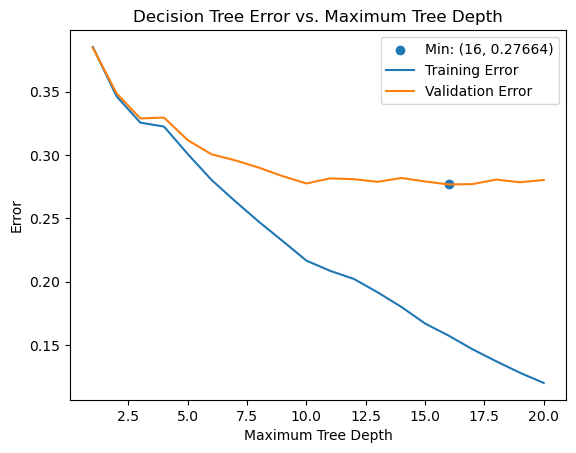

In [13]:
def plot_errors():
    min_index = np.argmin(depth_valid_errors)
    min_depth = depths[min_index]
    min_error = depth_valid_errors[min_index]

    plt.scatter(min_depth, min_error, label=f"Min: ({min_depth}, {min_error})")
    plt.plot(depths, depth_train_errors, label="Training Error")
    plt.plot(depths, depth_valid_errors, label="Validation Error")
    plt.title("Decision Tree Error vs. Maximum Tree Depth")
    plt.xlabel("Maximum Tree Depth")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

plot_errors()

#### Finding Optimal Criterion

In [28]:
criterions = ["gini", "entropy", "log_loss"]
criterion_train_errors = []
criterion_valid_errors = []

def calculate_errors():
    for criterion in criterions:
        clf = DecisionTreeClassifier(max_depth=16, criterion=criterion, random_state=seed)
        clf.fit(train_X, train_y)

        train_pred = clf.predict(train_X)
        valid_pred = clf.predict(valid_X)

        criterion_train_errors.append(1 - accuracy_score(train_y, train_pred))
        criterion_valid_errors.append(1 - accuracy_score(valid_y, valid_pred))

calculate_errors()

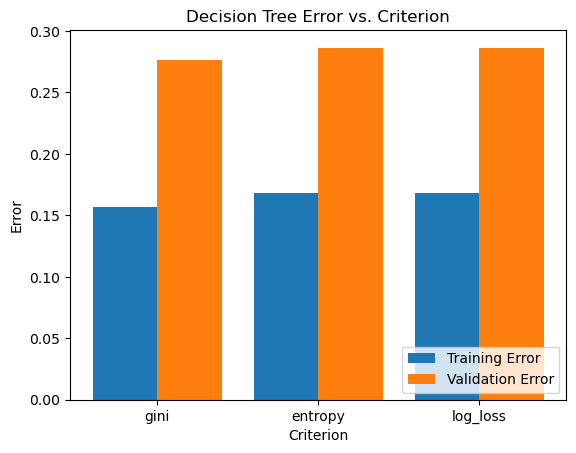

In [29]:
def plot_errors():
    width = 0.4
    x = np.arange(len(criterions))
    plt.bar(x - width / 2, criterion_train_errors, width, label="Training Error")
    plt.bar(x + width / 2, criterion_valid_errors, width, label="Validation Error")
    plt.title("Decision Tree Error vs. Criterion")
    plt.xlabel("Criterion")
    plt.ylabel("Error")
    plt.xticks(x, criterions)
    plt.legend(loc="lower right")
    plt.show()

plot_errors()

#### Finding Optimal Min Split Samples

In [30]:
minsplits = [i for i in range(2, 21)]
minsplit_train_errors = []
minsplit_valid_errors = []

def calculate_errors():
    for minsplit in minsplits:
        clf = DecisionTreeClassifier(max_depth=16, min_samples_split=minsplit, random_state=seed)
        clf.fit(train_X, train_y)

        train_pred = clf.predict(train_X)
        valid_pred = clf.predict(valid_X)

        minsplit_train_errors.append(1 - accuracy_score(train_y, train_pred))
        minsplit_valid_errors.append(1 - accuracy_score(valid_y, valid_pred))

calculate_errors()

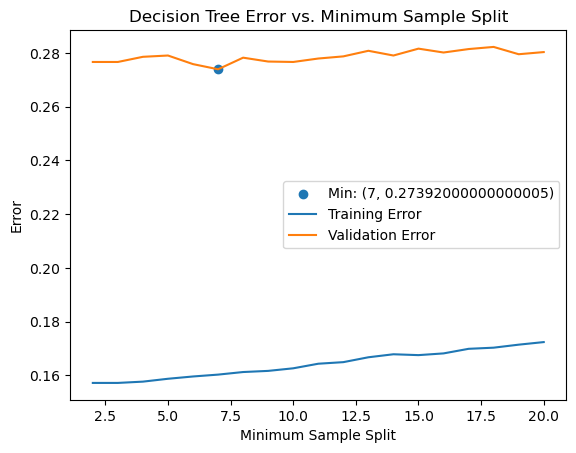

In [31]:
def plot_errors():
    min_index = np.argmin(minsplit_valid_errors)
    min_split = minsplits[min_index]
    min_error = minsplit_valid_errors[min_index]

    plt.scatter(min_split, min_error, label=f"Min: ({min_split}, {min_error})")
    plt.plot(minsplits, minsplit_train_errors, label="Training Error")
    plt.plot(minsplits, minsplit_valid_errors, label="Validation Error")
    plt.title("Decision Tree Error vs. Minimum Sample Split")
    plt.xlabel("Minimum Sample Split")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

plot_errors()

#### Finding Optimal Min Leaf Samples

In [33]:
minsamples = [i for i in range(1, 21)]
minsample_train_errors = []
minsample_valid_errors = []

def calculate_errors():
    for minsample in minsamples:
        clf = DecisionTreeClassifier(max_depth=16, min_samples_leaf=minsample, random_state=seed)
        clf.fit(train_X, train_y)

        train_pred = clf.predict(train_X)
        valid_pred = clf.predict(valid_X)

        minsample_train_errors.append(1 - accuracy_score(train_y, train_pred))
        minsample_valid_errors.append(1 - accuracy_score(valid_y, valid_pred))

calculate_errors()

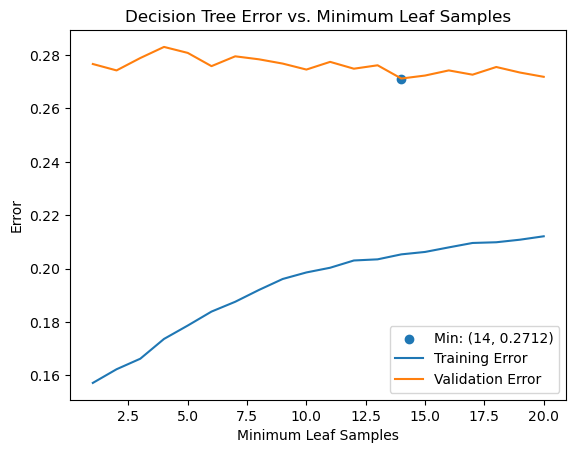

In [34]:
def plot_errors():
    min_index = np.argmin(minsample_valid_errors)
    min_sample = minsamples[min_index]
    min_error = minsample_valid_errors[min_index]

    plt.scatter(min_sample, min_error, label=f"Min: ({min_sample}, {min_error})")
    plt.plot(minsamples, minsample_train_errors, label="Training Error")
    plt.plot(minsamples, minsample_valid_errors, label="Validation Error")
    plt.title("Decision Tree Error vs. Minimum Leaf Samples")
    plt.xlabel("Minimum Leaf Samples")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

plot_errors()

#### Finding Optimal Hyperparams with Heuristic Grid Search

In [7]:
def calculate_optimal_params():
    param_grid = {
        "max_depth": [i for i in range(10, 21)],
        "min_samples_split": [i for i in range(2, 10)],
        "min_samples_leaf": [i for i in range(1, 21)],
    }

    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), param_grid)
    grid_search.fit(train_X, train_y)
    return grid_search

In [ ]:
grid_search = calculate_optimal_params()

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best model validation error:", 1 - grid_search.best_estimator_.score(valid_X, valid_y))